🔍 Sample full-size TRAIN images:


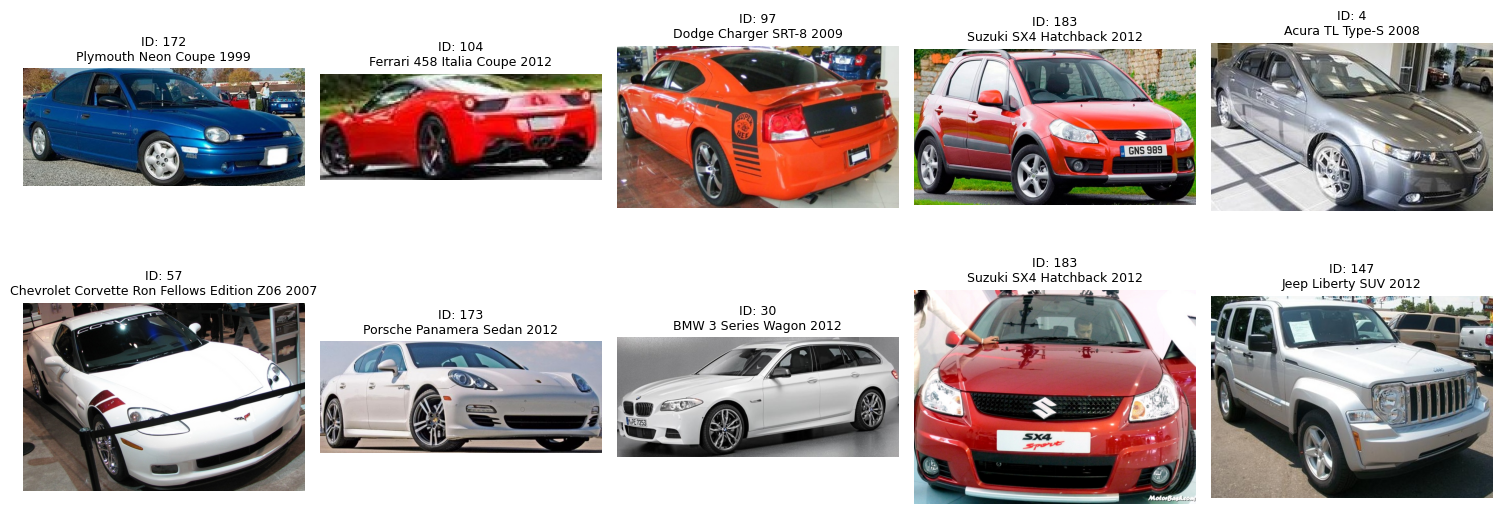

🔍 Sample full-size TEST images:


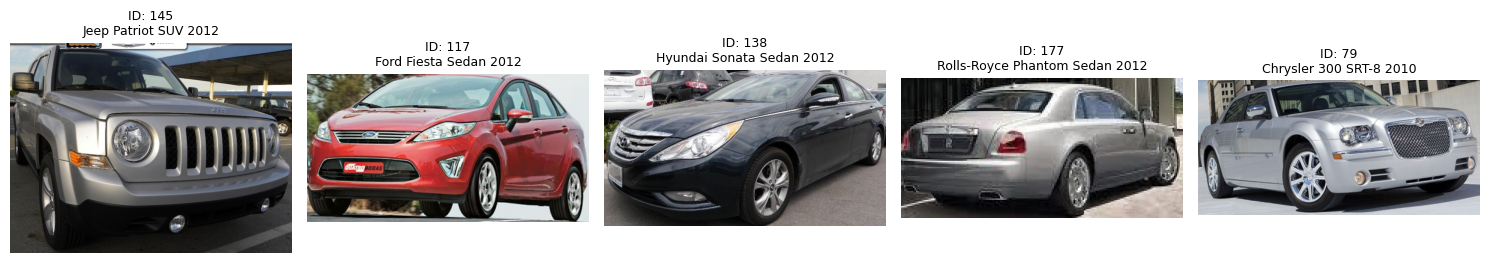

In [1]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt

# ============================================
# Step 1: Load annotations and extract class names
# ============================================
def build_filename_to_class_map(img_base_dir):
    """Create a mapping from filename to class folder name based on directory structure."""
    filename_to_class = {}
    for class_folder in os.listdir(img_base_dir):
        class_path = os.path.join(img_base_dir, class_folder)
        if not os.path.isdir(class_path):
            continue
        for fname in os.listdir(class_path):
            filename_to_class[fname] = class_folder
    return filename_to_class

def load_annotations(csv_path, img_base_dir):
    """Load annotations CSV and map images to their class folders."""
    df = pd.read_csv(csv_path)

    # Extract the base filename from the 'path' (relative path in CSV)
    df['basename'] = df['path'].apply(lambda x: os.path.basename(str(x)))

    # Map base filenames to their corresponding class folder
    filename_to_class = build_filename_to_class_map(img_base_dir)
    df['class_name'] = df['basename'].map(filename_to_class)

    # 🔧 Construct the full image path like Iran dataset
    df['path'] = df.apply(lambda row: os.path.join(img_base_dir, row['class_name'], row['basename']), axis=1)

    # Warn about missing mappings
    missing = df[df['class_name'].isnull()]
    if not missing.empty:
        print(f"⚠️ Warning: {len(missing)} images not found in directory structure.")
        print(missing['basename'].head())

    return df


# ============================================
# Step 2: Display sample images
# ============================================
def show_images(df, n=10, columns=5, cropped=False):
    """Display sample images using full paths in df['path']."""
    df = df[df['class_name'].notnull()]  # Remove rows with unknown class

    rows = (n + columns - 1) // columns
    plt.figure(figsize=(columns * 3, rows * 3))

    sample_df = df.sample(n=min(n, len(df))).reset_index(drop=True)

    for i in range(len(sample_df)):
        row = sample_df.iloc[i]
        img_path = row['path']
        class_name = row['class_name']
        class_id = row.get('class_id', 'N/A')

        image = cv2.imread(img_path)
        if image is None:
            print(f"Could not read image: {img_path}")
            continue

        # Crop if needed
        if cropped:
            xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
            image = image[ymin:ymax, xmin:xmax]

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, columns, i + 1)
        plt.imshow(image)
        plt.title(f"ID: {class_id}\n{class_name}", fontsize=9)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# ============================================
# Paths
# ============================================
TRAIN_IMG_DIR = "/kaggle/input/croppedstanfordcardataset/train"
TEST_IMG_DIR = "/kaggle/input/croppedstanfordcardataset/test"
ANNO_TRAIN = "/kaggle/input/croppedstanfordcardataset/train.csv"
ANNO_TEST = "/kaggle/input/croppedstanfordcardataset/test.csv"

# Load annotations
train_df = load_annotations(ANNO_TRAIN, TRAIN_IMG_DIR)
test_df = load_annotations(ANNO_TEST, TEST_IMG_DIR)

# Show sample images
print("🔍 Sample full-size TRAIN images:")
show_images(train_df, n=10, columns=5, cropped=False)

print("🔍 Sample full-size TEST images:")
show_images(test_df, n=5, columns=5, cropped=False)


In [2]:
# Create class_name to class_id mapping
unique_classes = sorted(train_df['class_name'].dropna().unique())
class_to_id = {name: idx for idx, name in enumerate(unique_classes)}
train_df['class_id'] = train_df['class_name'].map(class_to_id)
test_df['class_id'] = test_df['class_name'].map(class_to_id)

In [3]:
train_df.head()

path  class_id  \
0  /kaggle/input/croppedstanfordcardataset/train/...        23   
1  /kaggle/input/croppedstanfordcardataset/train/...         3   
2  /kaggle/input/croppedstanfordcardataset/train/...        88   
3  /kaggle/input/croppedstanfordcardataset/train/...       135   
4  /kaggle/input/croppedstanfordcardataset/train/...       110   

                            class_name   basename  
0                  Audi TTS Coupe 2012  00001.jpg  
1                  Acura TL Sedan 2012  00002.jpg  
2           Dodge Dakota Club Cab 2007  00003.jpg  
3     Hyundai Sonata Hybrid Sedan 2012  00004.jpg  
4  Ford F-450 Super Duty Crew Cab 2012  00005.jpg

🔍 Sample IRAN TRAIN images before merging:


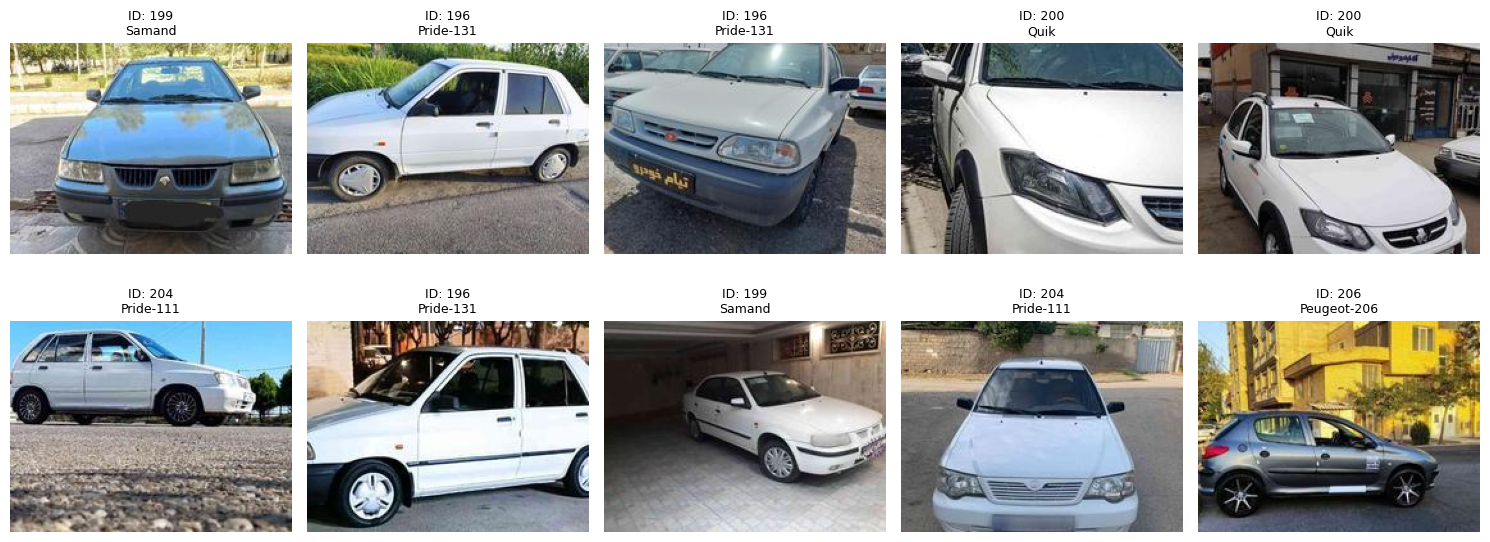

In [4]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load original annotations (already done in your code)
train_df = load_annotations(ANNO_TRAIN, TRAIN_IMG_DIR)
test_df = load_annotations(ANNO_TEST, TEST_IMG_DIR)

# ===========================================================
# Step 1: Parse Iran car dataset (skip 'split' folder)
# ===========================================================
IRAN_IMG_DIR = "/kaggle/input/iran-used-cars-dataset/iran-used-cars-dataset"

iran_class_names = [d for d in os.listdir(IRAN_IMG_DIR)
                    if os.path.isdir(os.path.join(IRAN_IMG_DIR, d)) and d.lower() != 'split']

iran_records = []

for class_name in iran_class_names:
    class_dir = os.path.join(IRAN_IMG_DIR, class_name)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            relative_path = os.path.join("iran", class_name, fname)
            iran_records.append({
                "path": relative_path,
                "class_name": class_name,
                "basename": fname
            })

iran_df = pd.DataFrame(iran_records)

# ===========================================================
# Step 2: Assign new class_ids (non-overlapping)
# ===========================================================
existing_classes = train_df['class_name'].unique().tolist() + test_df['class_name'].unique().tolist()
existing_class_set = set(existing_classes)
existing_class_count = len(set(existing_classes))

# Map new Iran classes to new IDs starting after existing ones
iran_class_to_id = {
    class_name: idx for idx, class_name in enumerate(iran_class_names, start=existing_class_count)
}
iran_df['class_id'] = iran_df['class_name'].map(iran_class_to_id)

# ===========================================================
# Step 3: Train/Test split of Iran dataset
# ===========================================================
train_iran_df, test_iran_df = train_test_split(iran_df, test_size=0.2, stratify=iran_df['class_name'], random_state=42)

# ===========================================================
# Step 4: Create full path by adding base directory prefix
# ===========================================================
train_iran_df['path'] = train_iran_df.apply(lambda row: os.path.join(IRAN_IMG_DIR, row['class_name'], row['basename']), axis=1)
test_iran_df['path'] = test_iran_df.apply(lambda row: os.path.join(IRAN_IMG_DIR, row['class_name'], row['basename']), axis=1)

print("🔍 Sample IRAN TRAIN images before merging:")
# We need to slightly adjust the image loading function to match the Iran dataset
show_images(train_iran_df, n=10, columns=5, cropped=False)




In [5]:
train_iran_df.head()

path   class_name  \
6263  /kaggle/input/iran-used-cars-dataset/iran-used...    Pride-111   
209   /kaggle/input/iran-used-cars-dataset/iran-used...    Pride-131   
2754  /kaggle/input/iran-used-cars-dataset/iran-used...       Samand   
4574  /kaggle/input/iran-used-cars-dataset/iran-used...  Renault-L90   
8181  /kaggle/input/iran-used-cars-dataset/iran-used...  Peugeot-206   

                   basename  class_id  
6263    Pride-111 (631).jpg       204  
209       Pride-131 (8).jpg       196  
2754        Samand (56).jpg       199  
4574  Renault-L90 (336).jpg       201  
8181  Peugeot-206 (124).jpg       206

In [6]:
# ===========================================================
# Step 5: Append to main train/test DataFrames
# ===========================================================

final_train_df = pd.concat([train_df, train_iran_df], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
final_test_df = pd.concat([test_df, test_iran_df], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)


print(f"✅ Final train samples: {len(final_train_df)}")
print(f"✅ Final test samples: {len(final_test_df)}")
print(f"🆕 Added Iran classes: {len(iran_class_names)} | Total classes: {final_train_df['class_id'].nunique() + final_test_df['class_id'].nunique()}")

✅ Final train samples: 15933
✅ Final test samples: 9989
🆕 Added Iran classes: 13 | Total classes: 416


In [7]:
final_train_df.head()

path  class_id  \
0  /kaggle/input/croppedstanfordcardataset/train/...        40   
1  /kaggle/input/iran-used-cars-dataset/iran-used...       201   
2  /kaggle/input/croppedstanfordcardataset/train/...       100   
3  /kaggle/input/iran-used-cars-dataset/iran-used...       207   
4  /kaggle/input/iran-used-cars-dataset/iran-used...       203   

                  class_name                basename  
0  Bentley Arnage Sedan 2009               06128.jpg  
1                Renault-L90    Renault-L90 (73).jpg  
2  FIAT 500 Convertible 2012               01660.jpg  
3                      Tiba2         Tiba2 (545).jpg  
4               Peugeot-Pars  Peugeot-Pars (621).jpg

🔍 Sample FINAL TRAIN images after merging and shuffling:


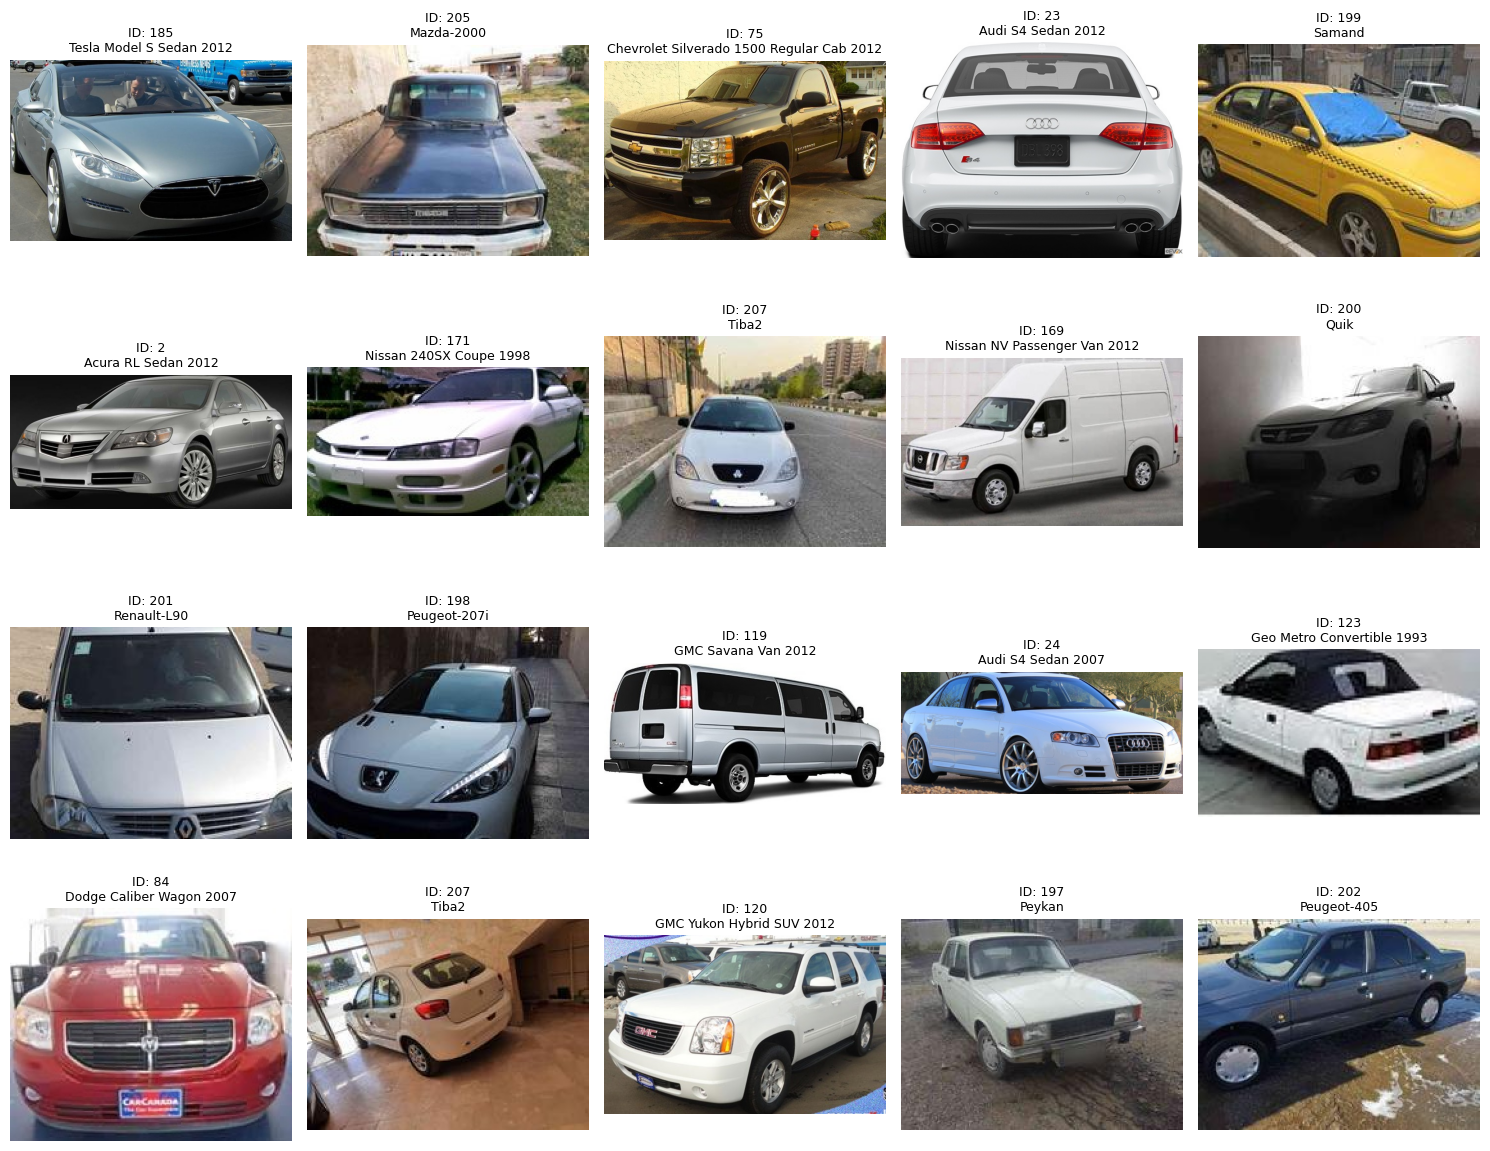

In [8]:
print("🔍 Sample FINAL TRAIN images after merging and shuffling:")
show_images(final_train_df, n=20, columns=5, cropped=False)


In [9]:
final_train_df.head()

path  class_id  \
0  /kaggle/input/croppedstanfordcardataset/train/...        40   
1  /kaggle/input/iran-used-cars-dataset/iran-used...       201   
2  /kaggle/input/croppedstanfordcardataset/train/...       100   
3  /kaggle/input/iran-used-cars-dataset/iran-used...       207   
4  /kaggle/input/iran-used-cars-dataset/iran-used...       203   

                  class_name                basename  
0  Bentley Arnage Sedan 2009               06128.jpg  
1                Renault-L90    Renault-L90 (73).jpg  
2  FIAT 500 Convertible 2012               01660.jpg  
3                      Tiba2         Tiba2 (545).jpg  
4               Peugeot-Pars  Peugeot-Pars (621).jpg

In [10]:
final_test_df.head()

path  class_id  \
0  /kaggle/input/croppedstanfordcardataset/test/L...       150   
1  /kaggle/input/croppedstanfordcardataset/test/A...         7   
2  /kaggle/input/iran-used-cars-dataset/iran-used...       198   
3  /kaggle/input/croppedstanfordcardataset/test/A...         1   
4  /kaggle/input/croppedstanfordcardataset/test/A...         7   

                        class_name                basename  
0  Lamborghini Reventon Coupe 2008               05840.jpg  
1         Acura ZDX Hatchback 2012               03059.jpg  
2                     Peugeot-207i  Peugeot-207i (372).jpg  
3       AM General Hummer SUV 2000               02665.jpg  
4         Acura ZDX Hatchback 2012               00036.jpg

In [11]:
from torchvision import transforms

image_size = (224, 224)

image_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.RandomCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))
    ])
}


🔍 Sample Train Images:


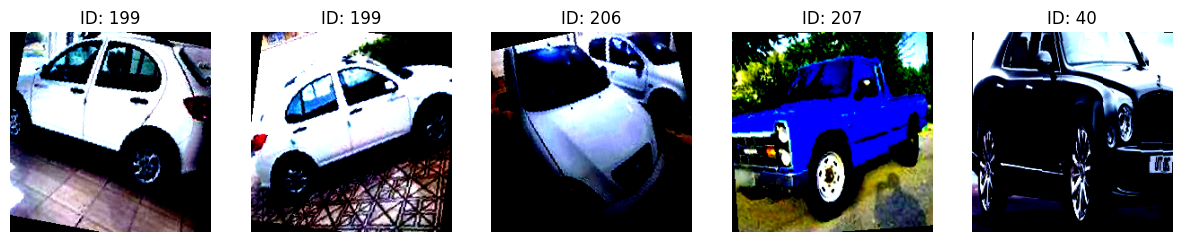

🔍 Sample Validation Images:


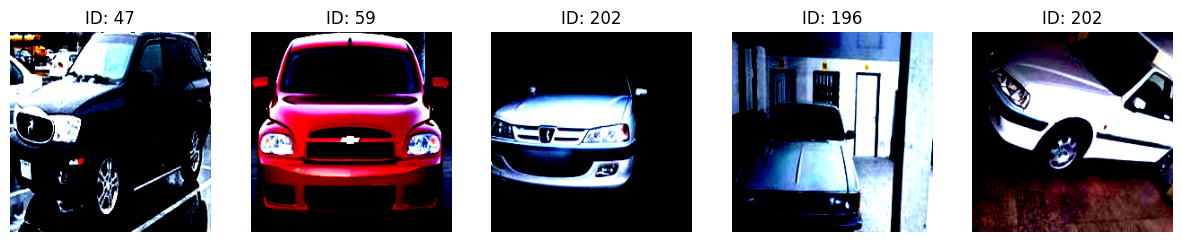

🔍 Sample Test Images:


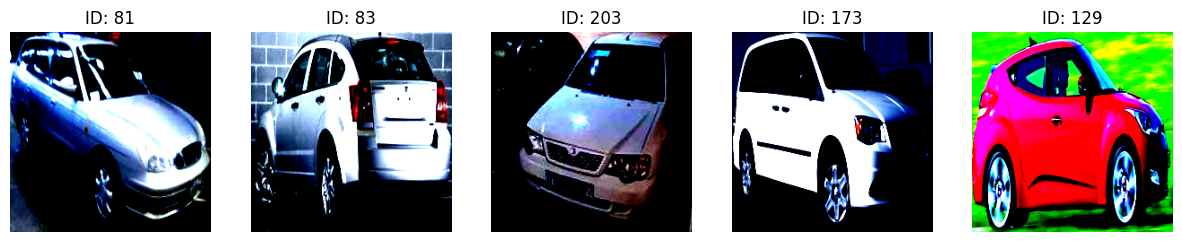

In [12]:
from torch.utils.data import Dataset, DataLoader

# ============================================
# Update class_id mapping (already exists)
# No need to remap class_id here again
# ============================================

# ============================================
# Split Final Combined Train into Train + Val
# ============================================
from sklearn.model_selection import train_test_split

train_percent = 1.0
val_percent = 1.0
test_percent = 1.0

train_df, val_df = train_test_split(
    final_train_df, test_size=0.2, random_state=42, stratify=final_train_df['class_id']
)

train_df = train_df.sample(frac=train_percent, random_state=42).reset_index(drop=True)
val_df = val_df.sample(frac=val_percent, random_state=42).reset_index(drop=True)
test_df = final_test_df.sample(frac=test_percent, random_state=42).reset_index(drop=True)

# ============================================
# Image Transforms (unchanged)
# ============================================

# Already defined earlier as `image_transforms`

# ============================================
# Create Datasets and Loaders
# NOTE: Iran and Stanford images live in different roots
# So we use full path instead of joining with class_name
# ============================================
class ImageDataset(Dataset):
    def __init__(self, annotations_df, transform=None):
        self.annotations_df = annotations_df
        self.transform = transform

    def __len__(self):
        return len(self.annotations_df)

    def __getitem__(self, idx):
        row = self.annotations_df.iloc[idx]
        class_id = row['class_id']
        img_path = row['path']  # full path already

        # Read and preprocess image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Optional cropping
        if all(key in row for key in ['xmin', 'ymin', 'xmax', 'ymax']):
            xmin, ymin, xmax, ymax = map(int, [row['xmin'], row['ymin'], row['xmax'], row['ymax']])
            image = image[ymin:ymax, xmin:xmax]

        if self.transform:
            image = self.transform(image)

        class_id -= 1  # ✅ Shift labels from 1-based to 0-based indexing

        return image, class_id


# Instantiate datasets and dataloaders
train_dataset = ImageDataset(train_df, transform=image_transforms['train'])
val_dataset = ImageDataset(val_df, transform=image_transforms['val'])
test_dataset = ImageDataset(test_df, transform=image_transforms['val'])  # Test usually uses val transform

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# ============================================
# Visualization (unchanged)
# ============================================
def show_images_from_loader(loader, n=5):
    plt.figure(figsize=(15, 10))
    
    for i, (images, labels) in enumerate(loader):
        for j in range(min(len(images), n)):
            ax = plt.subplot(1, n, j + 1)
            ax.imshow(images[j].permute(1, 2, 0).numpy())
            ax.set_title(f"ID: {labels[j].item()}")
            ax.axis('off')
        break  # Only show the first batch
    plt.show()

# Show samples
print("🔍 Sample Train Images:")
show_images_from_loader(train_loader)

print("🔍 Sample Validation Images:")
show_images_from_loader(val_loader)

print("🔍 Sample Test Images:")
show_images_from_loader(test_loader)


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score

# CBAM Attention Module
class CBAM(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(CBAM, self).__init__()
        self.channel_att = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction_ratio, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction_ratio, channels, 1, bias=False)
        )
        self.spatial_att = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        avg_pool = torch.mean(x, dim=(2, 3), keepdim=True)
        max_pool, _ = torch.max(x, dim=2, keepdim=True)
        max_pool, _ = torch.max(max_pool, dim=3, keepdim=True)
        channel_att = self.channel_att(avg_pool + max_pool).sigmoid()
        x = x * channel_att

        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_att = self.spatial_att(torch.cat([avg_out, max_out], dim=1))
        return x * spatial_att


# Cross-Attention Mechanism
class CrossAttention(nn.Module):
    def __init__(self, d_model):
        super(CrossAttention, self).__init__()
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.scale = np.sqrt(d_model)

    def forward(self, x1, x2):
        q = self.query(x1)
        k = self.key(x2)
        v = self.value(x2)
        attn = torch.softmax(torch.bmm(q, k.transpose(1, 2)) / self.scale, dim=-1)
        return torch.bmm(attn, v)

# Hybrid Model Definition
class EfficientDense_CBAM_CrossAttention(nn.Module):
    def __init__(self, num_classes):
        super(EfficientDense_CBAM_CrossAttention, self).__init__()
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.densenet = models.densenet121(pretrained=True)

        self.efficientnet.features[0].requires_grad = False
        self.densenet.features[0].requires_grad = False

        self.cbam_efficient = CBAM(1280)
        self.cbam_dense = CBAM(1024)

        self.cross_attention = CrossAttention(512)
        self.fc_efficient = nn.Linear(1280, 512)
        self.fc_dense = nn.Linear(1024, 512)

        self.classifier = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        fe = self.efficientnet.features(x)
        fd = self.densenet.features(x)

        fe = self.cbam_efficient(fe)
        fd = self.cbam_dense(fd)

        fe = F.adaptive_avg_pool2d(fe, (1, 1)).view(x.size(0), -1)
        fd = F.adaptive_avg_pool2d(fd, (1, 1)).view(x.size(0), -1)

        fe = self.fc_efficient(fe).unsqueeze(1)
        fd = self.fc_dense(fd).unsqueeze(1)

        cross_attended = self.cross_attention(fe, fd).squeeze(1)
        out = self.dropout(cross_attended)
        return self.classifier(out)

# Top-K Accuracy
def calculate_top_k_accuracy(output, target, k=5):
    _, pred = output.topk(k, dim=1)
    correct = pred.eq(target.view(-1, 1).expand_as(pred))
    return correct.any(dim=1).float().mean().item()

# Training Function
def train(model, criterion, optimizer, train_loader, val_loader, save_location,
          early_stop=3, n_epochs=1, print_every=1, scheduler=None):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    valid_loss_min = np.inf
    stop_count = 0
    best_epoch = 0
    best_top5_acc = 0
    history = []

    for epoch in range(n_epochs):
        model.train()
        train_loss, train_top1, train_top5 = 0, 0, 0
        train_labels, train_preds = [], []

        for data, label in tqdm(train_loader, desc=f"Epoch {epoch+1} - Train"):
            data, label = data.to(device), label.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            _, pred = output.max(1)
            train_top1 += pred.eq(label).sum().item()
            train_top5 += calculate_top_k_accuracy(output, label, k=5) * data.size(0)

            train_labels.extend(label.cpu().numpy())
            train_preds.extend(pred.cpu().numpy())

        val_loss, val_top1, val_top5 = 0, 0, 0
        val_labels, val_preds = [], []
        model.eval()

        with torch.no_grad():
            for data, label in tqdm(val_loader, desc=f"Epoch {epoch+1} - Val"):
                data, label = data.to(device), label.to(device)
                output = model(data)
                loss = criterion(output, label)

                val_loss += loss.item() * data.size(0)
                _, pred = output.max(1)
                val_top1 += pred.eq(label).sum().item()
                val_top5 += calculate_top_k_accuracy(output, label, k=5) * data.size(0)

                val_labels.extend(label.cpu().numpy())
                val_preds.extend(pred.cpu().numpy())

        num_train = len(train_loader.dataset)
        num_val = len(val_loader.dataset)

        history.append([
            train_loss / num_train,
            val_loss / num_val,
            train_top1 / num_train,
            val_top1 / num_val,
            train_top5 / num_train,
            val_top5 / num_val
        ])

        if (epoch + 1) % print_every == 0:
            print(f"\nEpoch {epoch+1}: Train Loss: {train_loss/num_train:.4f} | Val Loss: {val_loss/num_val:.4f}")
            print(f"Top-1 Train Acc: {(train_top1 / num_train)*100:.2f}%, Top-5: {(train_top5 / num_train)*100:.2f}%")
            print(f"Top-1 Val Acc: {(val_top1 / num_val)*100:.2f}%, Top-5: {(val_top5 / num_val)*100:.2f}%")
            print(f"Train Precision: {precision_score(train_labels, train_preds, average='macro', zero_division=1):.2f} | Recall: {recall_score(train_labels, train_preds, average='macro', zero_division=1):.2f}")
            print(f"Val Precision: {precision_score(val_labels, val_preds, average='macro', zero_division=1):.2f} | Recall: {recall_score(val_labels, val_preds, average='macro', zero_division=1):.2f}")

        if scheduler is not None:
            scheduler.step()

        if val_loss < valid_loss_min:
            torch.save({'state_dict': model.state_dict()}, save_location)
            valid_loss_min = val_loss
            best_top5_acc = val_top5 / num_val
            best_epoch = epoch
            stop_count = 0
        else:
            stop_count += 1
            if stop_count >= early_stop:
                print(f"\nEarly stopping at epoch {epoch+1}. Best Top-5 Acc: {best_top5_acc*100:.2f}%")
                model.load_state_dict(torch.load(save_location)['state_dict'])
                return model, pd.DataFrame(history, columns=[
                    'train_loss', 'val_loss',
                    'train_top1_acc', 'val_top1_acc',
                    'train_top5_acc', 'val_top5_acc'
                ])

    print(f"\nTraining complete. Best epoch: {best_epoch} with Top-5 Acc: {best_top5_acc*100:.2f}%")
    return model, pd.DataFrame(history, columns=[
        'train_loss', 'val_loss',
        'train_top1_acc', 'val_top1_acc',
        'train_top5_acc', 'val_top5_acc'
    ])





In [14]:
# --- Run Setup ---

from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

n_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Fix here: Set num_classes=208
model = EfficientDense_CBAM_CrossAttention(num_classes=208)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)

model, history = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    save_location='efficient_dense_cbam_crossattention.pt',
    early_stop=4,
    n_epochs=n_epochs,
    scheduler=scheduler,
    print_every=1
)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 147MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights

Using 2 GPUs


Epoch 1 - Val: 100%|██████████| 100/100 [00:27<00:00,  3.59it/s]



Epoch 1: Train Loss: 2.9675 | Val Loss: 1.9038
Top-1 Train Acc: 37.20%, Top-5: 52.01%
Top-1 Val Acc: 53.25%, Top-5: 71.48%
Train Precision: 0.10 | Recall: 0.08
Val Precision: 0.63 | Recall: 0.20


Epoch 2 - Val: 100%|██████████| 100/100 [00:27<00:00,  3.64it/s]



Epoch 2: Train Loss: 1.7003 | Val Loss: 1.0902
Top-1 Train Acc: 57.27%, Top-5: 77.84%
Top-1 Val Acc: 70.44%, Top-5: 90.21%
Train Precision: 0.28 | Recall: 0.28
Val Precision: 0.65 | Recall: 0.49


Epoch 3 - Val: 100%|██████████| 100/100 [00:27<00:00,  3.62it/s]



Epoch 3: Train Loss: 1.0305 | Val Loss: 0.7027
Top-1 Train Acc: 71.46%, Top-5: 90.84%
Top-1 Val Acc: 79.76%, Top-5: 95.17%
Train Precision: 0.52 | Recall: 0.52
Val Precision: 0.74 | Recall: 0.65


Epoch 4 - Val: 100%|██████████| 100/100 [00:27<00:00,  3.63it/s]



Epoch 4: Train Loss: 0.6754 | Val Loss: 0.5861
Top-1 Train Acc: 79.98%, Top-5: 95.72%
Top-1 Val Acc: 84.09%, Top-5: 95.89%
Train Precision: 0.66 | Recall: 0.66
Val Precision: 0.81 | Recall: 0.72


Epoch 5 - Val: 100%|██████████| 100/100 [00:27<00:00,  3.63it/s]



Epoch 5: Train Loss: 0.4546 | Val Loss: 0.4727
Top-1 Train Acc: 86.45%, Top-5: 97.98%
Top-1 Val Acc: 86.29%, Top-5: 97.77%
Train Precision: 0.78 | Recall: 0.77
Val Precision: 0.82 | Recall: 0.77


Epoch 6 - Val: 100%|██████████| 100/100 [00:27<00:00,  3.63it/s]



Epoch 6: Train Loss: 0.3044 | Val Loss: 0.3907
Top-1 Train Acc: 90.40%, Top-5: 99.11%
Top-1 Val Acc: 88.36%, Top-5: 97.90%
Train Precision: 0.84 | Recall: 0.83
Val Precision: 0.84 | Recall: 0.81


Epoch 7 - Val: 100%|██████████| 100/100 [00:27<00:00,  3.64it/s]



Epoch 7: Train Loss: 0.2029 | Val Loss: 0.2967
Top-1 Train Acc: 93.57%, Top-5: 99.67%
Top-1 Val Acc: 91.59%, Top-5: 98.68%
Train Precision: 0.89 | Recall: 0.89
Val Precision: 0.88 | Recall: 0.86


Epoch 8 - Val: 100%|██████████| 100/100 [00:27<00:00,  3.69it/s]



Epoch 8: Train Loss: 0.1472 | Val Loss: 0.2941
Top-1 Train Acc: 95.33%, Top-5: 99.82%
Top-1 Val Acc: 91.62%, Top-5: 98.78%
Train Precision: 0.92 | Recall: 0.92
Val Precision: 0.88 | Recall: 0.86


Epoch 9 - Val: 100%|██████████| 100/100 [00:27<00:00,  3.65it/s]



Epoch 9: Train Loss: 0.1095 | Val Loss: 0.2613
Top-1 Train Acc: 96.55%, Top-5: 99.93%
Top-1 Val Acc: 92.38%, Top-5: 98.74%
Train Precision: 0.94 | Recall: 0.94
Val Precision: 0.88 | Recall: 0.87


Epoch 10 - Val: 100%|██████████| 100/100 [00:26<00:00,  3.70it/s]



Epoch 10: Train Loss: 0.0897 | Val Loss: 0.2569
Top-1 Train Acc: 97.26%, Top-5: 99.95%
Top-1 Val Acc: 92.63%, Top-5: 98.87%
Train Precision: 0.95 | Recall: 0.95
Val Precision: 0.89 | Recall: 0.88

Training complete. Best epoch: 9 with Top-5 Acc: 98.87%


In [17]:
import torch
import matplotlib.pyplot as plt

def predict_and_show_images(model, data_loader, n=12, device='cuda'):
    model.eval()  # Set model to evaluation mode
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():  # No need to compute gradients during inference
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Get model predictions
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Show images and predictions
            for i in range(inputs.size()[0]):
                if images_so_far == n:
                    return
                ax = plt.subplot(3, 4, images_so_far + 1)  # Adjust for your grid size
                ax.imshow(inputs.cpu().data[i].permute(1, 2, 0))  # Convert to HWC format for display
                ax.set_title(f"True: {labels[i].item()}, Pred: {preds[i].item()}")
                ax.axis('off')
                images_so_far += 1

    plt.show()


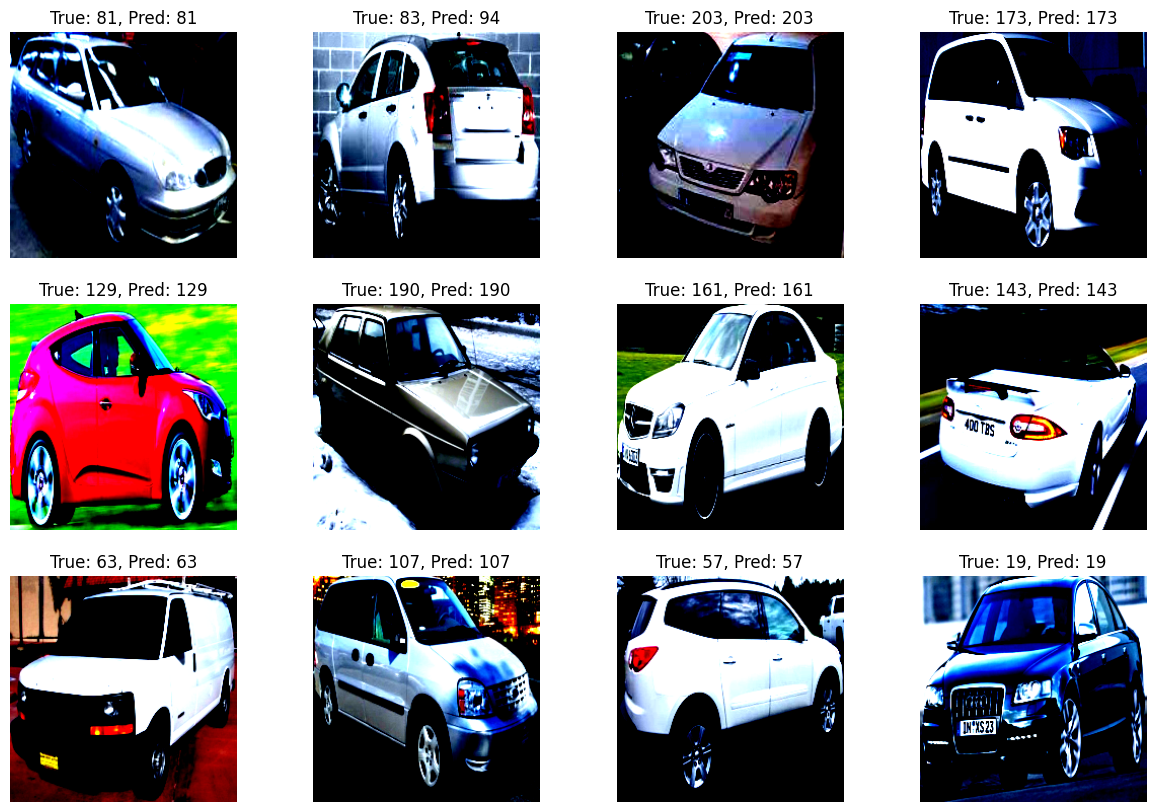

In [18]:
predict_and_show_images(model, test_loader, n=12, device='cuda')
